In [1]:
#Instalamos las dependencias necesarias que no posee Google Colab.
%pip install bayesian-optimization
%pip install mlxtend --upgrade --no-deps
%pip install tensorflow
%pip install imbalanced-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Importamos los paquetes necesarios para el proyecto
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import numpy as np
import json
import time


In [ ]:
#Descargamos el set de datos subido previamente al Google Drive .
path_train = "UNSW_NB15_training-set.csv"
path_test = "UNSW_NB15_testing-set.csv"


#Leemos los datos
df_train=pd.read_csv(path_train,dtype='unicode')
df_test=pd.read_csv(path_test,dtype='unicode')

#print(df_train.columns)
#print(df_test.columns)

#Quitamos las columnas no necesarias
df_train.drop('id', axis=1, inplace=True)
df_train.drop('label', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_test.drop('label', axis=1, inplace=True)

#print(df_train.columns)
#print(df_test.columns)

In [4]:
#Concatenamos el set de entrenamiento y el de test para manipular directamente el conjunto.
df = pd.concat([df_train,df_test],axis=0)

Shape of dataFrame: (257673, 43) 

Number of samples per attack


attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64


Plotting balance of dataFrame


<Axes: title={'center': 'Balance of dataset (%)'}, ylabel='proportion'>

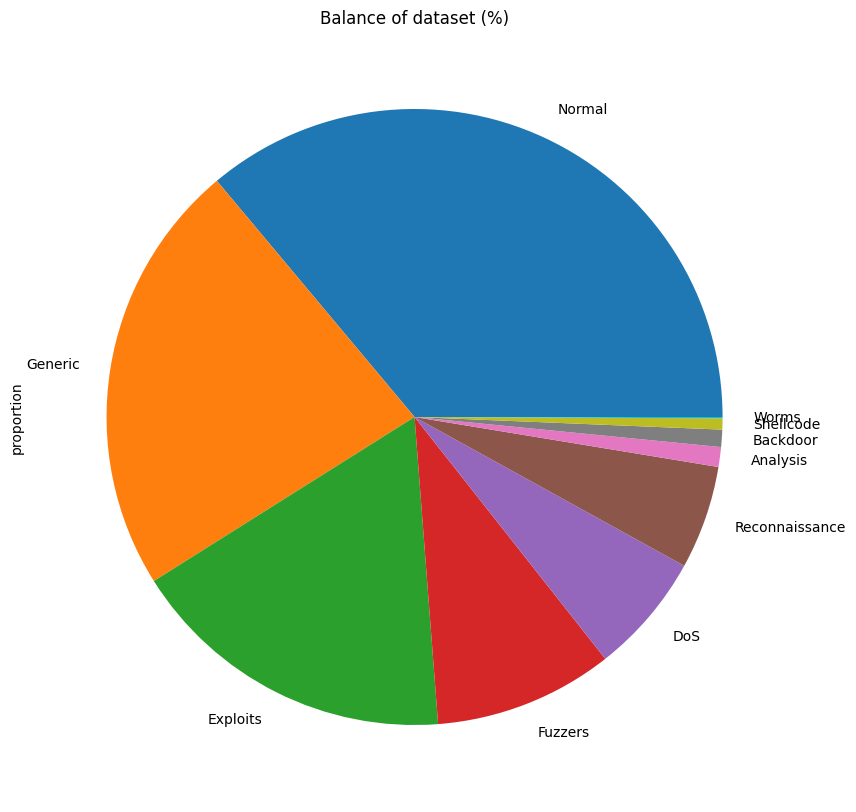

In [5]:
#Visualización en una gráfica circular del peso de cada clase
print("Shape of dataFrame: {} \n".format(df.shape))
print("Number of samples per attack")
display(df['attack_cat'].value_counts())
print("")
print("Plotting balance of dataFrame")
df_plot = (df['attack_cat'].value_counts(normalize=True) *100)
df_plot.plot(kind='pie',figsize=(10,10),title='Balance of dataset (%)')

In [6]:
#Conversión de los datos tipo string a enteros en un rango entre 0 y 255 (1 Byte de información)
def encode_string_byte (df,name):
  df[name] = LabelEncoder().fit_transform(df[name])

encode_string_byte (df,'proto')
encode_string_byte (df,'state')
encode_string_byte (df,'service')


In [7]:
#Normalización de los números enteros en valores decimales en rango entre 0 y 1
def numerical_minmax_normalization (df, name):
  x = df[name].values.reshape(-1,1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df[name] = x_scaled

numerical_minmax_normalization(df,'dur')
numerical_minmax_normalization(df,'spkts')
numerical_minmax_normalization(df,'dpkts')
numerical_minmax_normalization(df,'sbytes')
numerical_minmax_normalization(df,'dbytes')
numerical_minmax_normalization(df,'rate')
numerical_minmax_normalization(df,'sttl')
numerical_minmax_normalization(df,'dttl')
numerical_minmax_normalization(df,'sload')
numerical_minmax_normalization(df,'dload')
numerical_minmax_normalization(df,'sloss')
numerical_minmax_normalization(df,'dloss')
numerical_minmax_normalization(df,'sinpkt')
numerical_minmax_normalization(df,'dinpkt')
numerical_minmax_normalization(df,'sjit')
numerical_minmax_normalization(df,'djit')
numerical_minmax_normalization(df,'swin')
numerical_minmax_normalization(df,'stcpb')
numerical_minmax_normalization(df,'dtcpb')
numerical_minmax_normalization(df,'dwin')
numerical_minmax_normalization(df,'tcprtt')
numerical_minmax_normalization(df,'synack')
numerical_minmax_normalization(df,'ackdat')
numerical_minmax_normalization(df,'smean')
numerical_minmax_normalization(df,'dmean')
numerical_minmax_normalization(df,'trans_depth')
numerical_minmax_normalization(df,'response_body_len')
numerical_minmax_normalization(df,'ct_srv_src')
numerical_minmax_normalization(df,'ct_state_ttl')
numerical_minmax_normalization(df,'ct_dst_ltm')
numerical_minmax_normalization(df,'ct_src_dport_ltm')
numerical_minmax_normalization(df,'ct_dst_sport_ltm')
numerical_minmax_normalization(df,'ct_dst_src_ltm')
numerical_minmax_normalization(df,'is_ftp_login')
numerical_minmax_normalization(df,'ct_ftp_cmd')
numerical_minmax_normalization(df,'ct_flw_http_mthd')
numerical_minmax_normalization(df,'ct_src_ltm')
numerical_minmax_normalization(df,'ct_srv_dst')
numerical_minmax_normalization(df,'is_sm_ips_ports')

In [8]:
#Mapeo de los valores normalizados del paso anterior a valores enteros entre 0 y 255 (1 Byte de información)
def numerical_split_ohe (df,name):
  pd_to_np = df[name].tolist()
  np_split = []

  categories = np.linspace(0, 1, num=256,endpoint=False)
  quantization = range(0,256)

  for value in pd_to_np:
    for i in range(len(categories)-1):
      if (categories[i] <= float(value) <= categories[i+1]):
        np_split.append(quantization[i])
        break
      if (float(value) > categories[-1]):
        np_split.append(quantization[-1])
        break

  df[name] = np_split


numerical_split_ohe(df,'dur')
numerical_split_ohe(df,'spkts')
numerical_split_ohe(df,'dpkts')
numerical_split_ohe(df,'sbytes')
numerical_split_ohe(df,'dbytes')
numerical_split_ohe(df,'rate')
numerical_split_ohe(df,'sttl')
numerical_split_ohe(df,'dttl')
numerical_split_ohe(df,'sload')
numerical_split_ohe(df,'dload')
numerical_split_ohe(df,'sloss')
numerical_split_ohe(df,'dloss')
numerical_split_ohe(df,'sinpkt')
numerical_split_ohe(df,'dinpkt')
numerical_split_ohe(df,'sjit')
numerical_split_ohe(df,'djit')
numerical_split_ohe(df,'swin')
numerical_split_ohe(df,'stcpb')
numerical_split_ohe(df,'dtcpb')
numerical_split_ohe(df,'dwin')
numerical_split_ohe(df,'tcprtt')
numerical_split_ohe(df,'synack')
numerical_split_ohe(df,'ackdat')
numerical_split_ohe(df,'smean')
numerical_split_ohe(df,'dmean')
numerical_split_ohe(df,'trans_depth')
numerical_split_ohe(df,'response_body_len')
numerical_split_ohe(df,'ct_srv_src')
numerical_split_ohe(df,'ct_state_ttl')
numerical_split_ohe(df,'ct_dst_ltm')
numerical_split_ohe(df,'ct_src_dport_ltm')
numerical_split_ohe(df,'ct_dst_sport_ltm')
numerical_split_ohe(df,'ct_dst_src_ltm')
numerical_split_ohe(df,'is_ftp_login')
numerical_split_ohe(df,'ct_ftp_cmd')
numerical_split_ohe(df,'ct_flw_http_mthd')
numerical_split_ohe(df,'ct_src_ltm')
numerical_split_ohe(df,'ct_srv_dst')
numerical_split_ohe(df,'is_sm_ips_ports')

In [9]:
#Quitando la columna attack_cat y guardandola en la variable y.
y_column = df['attack_cat']
df.drop('attack_cat',axis=1,inplace=True)
dummies = pd.get_dummies(y_column)
y = dummies.values

In [10]:
# Balanceo del dataset mediante SMOTE (930000 por cada clase) y normalización entre -0.5 y 0.5
x = []
for image in np.array(df.to_numpy()):
    x.append((image / 255.0) - 0.5)
x = np.array(x)  # Convertimos la lista a un array numpy

# Balanceamos el dataset usando SMOTE
sm = SMOTE(random_state=0)
x_resampled, y_resampled = sm.fit_resample(x, y)

# Verificamos las nuevas dimensiones
print("Dimensiones del dataset original:", x.shape)
print("Dimensiones del dataset resampleado:", x_resampled.shape)


Dimensiones del dataset original: (257673, 42)
Dimensiones del dataset resampleado: (930000, 42)


In [11]:
# Separación del dataset resampleado en un conjunto de entrenamiento y validación
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x_resampled, y_resampled):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

# Verificar dimensiones de los conjuntos
print("Dimensiones del conjunto de entrenamiento (X):", x_train.shape)
print("Dimensiones del conjunto de validación (X):", x_test.shape)
print("Dimensiones del conjunto de entrenamiento (Y):", y_train.shape)
print("Dimensiones del conjunto de validación (Y):", y_test.shape)

Dimensiones del conjunto de entrenamiento (X): (697500, 42)
Dimensiones del conjunto de validación (X): (232500, 42)
Dimensiones del conjunto de entrenamiento (Y): (697500, 10)
Dimensiones del conjunto de validación (Y): (232500, 10)


In [12]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)


Guardar-Cargar modelo

In [3]:
import os
import numpy as np
import json
import tensorflow as tf
import time

def guardar_modelo_y_data(model, history, val_dataset, y_test, model_name, training_time):
    model_folder = f"./{model_name}_files"
    os.makedirs(model_folder, exist_ok=True)
    model_path = os.path.join(model_folder, f"{model_name}_model.keras")
    model.save(model_path)
    print(f"Modelo guardado como {model_path}")
    history_path = os.path.join(model_folder, f"{model_name}_training_history.json")
    with open(history_path, 'w') as f:
        history_data = {
            "history": history.history,
            "training_time": training_time  
        }
        json.dump(history_data, f)
    print(f"Historial guardado como {history_path}")
    y_pred = model.predict(val_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    np.save(os.path.join(model_folder, f"y_pred_{model_name}.npy"), y_pred_classes)
    np.save(os.path.join(model_folder, f"y_true_{model_name}.npy"), y_test)
    print(f"Predicciones y etiquetas guardadas en {model_folder}")


In [4]:
import os
import numpy as np
import json
import tensorflow as tf
import time

def cargar_modelo_y_data(model_name):

    model_folder = f"./{model_name}_files"
    if not os.path.exists(model_folder):
        raise FileNotFoundError(f"La carpeta {model_folder} no existe. Verifica el nombre del modelo.")
    model_path = os.path.join(model_folder, f"{model_name}_model.keras")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    history_path = os.path.join(model_folder, f"{model_name}_training_history.json")
    with open(history_path, 'r') as f:
        history_data = json.load(f)
    print(f"Historial de entrenamiento cargado desde {history_path}")
    y_pred_path = os.path.join(model_folder, f"y_pred_{model_name}.npy")
    y_true_path = os.path.join(model_folder, f"y_true_{model_name}.npy")
    y_pred = np.load(y_pred_path)
    y_true = np.load(y_true_path)
    print(f"Predicciones cargadas desde {y_pred_path}")
    print(f"Etiquetas reales cargadas desde {y_true_path}")
    return {
        "model": model,
        "history": history_data["history"],
        "y_pred": y_pred,
        "y_true": y_true,
        "training_time": history_data["training_time"]  # Cargar el tiempo de ejecución
    }


Funciones de entrenamiento

In [15]:
import time
import numpy as np
import tensorflow as tf

# MODELO LSTM
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_layer = tf.keras.layers.LSTM(128)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(lstm_layer)
output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# COMPILAR EL MODELO
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CREAR tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,850 (265.04 KB)

 Trainable params: 67,850 (265.04 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_lstm = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 263s 24ms/step - accuracy: 0.3825 - loss: 1.6109 - val_accuracy: 0.5111 - val_loss: 1.2844
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 431s 40ms/step - accuracy: 0.5469 - loss: 1.1825 - val_accuracy: 0.6242 - val_loss: 0.9629
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 431s 40ms/step - accuracy: 0.6191 - loss: 0.9751 - val_accuracy: 0.6511 - val_loss: 0.8992
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 415s 38ms/step - accuracy: 0.6387 - loss: 0.9187 - val_accuracy: 0.6553 - val_loss: 0.8649
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 409s 37ms/step - accuracy: 0.6533 - loss: 0.8773 - val_accuracy: 0.6568 - val_loss: 0.8560
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 410s 38ms/step - accuracy: 0.6621 - loss: 0.8512 - val_accuracy: 0.6690 - val_loss: 0.8456
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 412s 38ms/step - accuracy: 0.6704 - loss: 0.8274 - val_accuracy: 0.6831 - val_loss: 0.7893
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 413

In [17]:
guardar_modelo_y_data(model, history_lstm, val_dataset, y_test, "LSTM", training_time)


Modelo guardado como ./LSTM_files\LSTM_model.keras
Historial guardado como ./LSTM_files\LSTM_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step
Predicciones y etiquetas guardadas en ./LSTM_files


In [21]:
import time
import numpy as np
import tensorflow as tf

# MODELO GRU
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
gru_layer = tf.keras.layers.GRU(128)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(gru_layer)
output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# COMPILAR EL MODELO
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CREAR tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,594 (201.54 KB)

 Trainable params: 51,594 (201.54 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 183s 17ms/step - accuracy: 0.3957 - loss: 1.5795 - val_accuracy: 0.6024 - val_loss: 1.0116
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 173s 16ms/step - accuracy: 0.6286 - loss: 0.9491 - val_accuracy: 0.6715 - val_loss: 0.8309
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 175s 16ms/step - accuracy: 0.6684 - loss: 0.8353 - val_accuracy: 0.6811 - val_loss: 0.7843
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 178s 16ms/step - accuracy: 0.6822 - loss: 0.7920 - val_accuracy: 0.6957 - val_loss: 0.7521
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 178s 16ms/step - accuracy: 0.6912 - loss: 0.7659 - val_accuracy: 0.6930 - val_loss: 0.7519
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 183s 17ms/step - accuracy: 0.6964 - loss: 0.7472 - val_accuracy: 0.7027 - val_loss: 0.7224
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 178s 16ms/step - accuracy: 0.7011 - loss: 0.7326 - val_accuracy: 0.7028 - val_loss: 0.7252
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 182

In [20]:
guardar_modelo_y_data(model, history_gru, val_dataset, y_test, "GRU", training_time)

Modelo guardado como ./GRU_files\GRU_model.keras
Historial guardado como ./GRU_files\GRU_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
Predicciones y etiquetas guardadas en ./GRU_files


In [ ]:
import time
import numpy as np
import tensorflow as tf

# MODELO RNN
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
rnn_layer = tf.keras.layers.SimpleRNN(128)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(rnn_layer)
output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# COMPILAR EL MODELO
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CREAR tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,930 (70.04 KB)

 Trainable params: 17,930 (70.04 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_rnn = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")


Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.4875 - loss: 1.3477 - val_accuracy: 0.6162 - val_loss: 0.9553
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - accuracy: 0.6183 - loss: 0.9661 - val_accuracy: 0.6357 - val_loss: 0.9492
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.6308 - loss: 0.9349 - val_accuracy: 0.6348 - val_loss: 0.9222
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.6360 - loss: 0.9252 - val_accuracy: 0.6395 - val_loss: 0.9151
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - accuracy: 0.6389 - loss: 0.9225 - val_accuracy: 0.6279 - val_loss: 0.9580
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.6250 - loss: 0.9688 - val_accuracy: 0.6414 - val_loss: 0.9010
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.6134 - loss: 1.0062 - val_accuracy: 0.6380 - val_loss: 0.9199
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - ac

In [23]:
guardar_modelo_y_data(model, history_rnn, val_dataset, y_test, "RNN", training_time)

Modelo guardado como ./RNN_files\RNN_model.keras
Historial guardado como ./RNN_files\RNN_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Predicciones y etiquetas guardadas en ./RNN_files


In [23]:
import tensorflow as tf
import numpy as np

# MODELO GRU + ATENCION ADITIVA
class Atencion_aditivo(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Atencion_aditivo, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # Para el estado oculto
        self.W2 = tf.keras.layers.Dense(units)  # Para las salidas del codificador
        self.V = tf.keras.layers.Dense(1)       # Para las puntuaciones

    def call(self, hidden_state, encoder_outputs):
        # hidden_state: (batch_size, units)
        # encoder_outputs: (batch_size, timesteps, units)

        # Expande el estado oculto para tener una dimensión temporal
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)  # (batch_size, 1, units)

        # Calcula las puntuaciones de atención
        score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(encoder_outputs)))  # (batch_size, timesteps, 1)

        # Calcula los pesos de atención
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, timesteps, 1)

        # Calcula el vector de contexto
        context_vector = attention_weights * encoder_outputs  # (batch_size, timesteps, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, units)

        return context_vector, attention_weights

# MODELO GRU + ATENCION ADITIVA
def GRU_aditivo(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True, return_state=True)
    encoder_outputs, hidden_state = gru_layer(inputs)

    # Atención aditiva
    attention_layer = Atencion_aditivo(128)
    context_vector, attention_weights = attention_layer(hidden_state, encoder_outputs)
    
    # Salidas del modelo
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
model_aditivogru = GRU_aditivo(input_shape, num_classes)

# COMPILAR EL MODELO
model_aditivogru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Creación de tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_aditivogru.summary()




Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 42, 128), │     50,304 │ input_layer_6[0]… │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atencion_aditivo    │ [(None, 128),     │     33,153 │ gru_5[0][1],      │
│ (Atencion_aditivo)  │ (None, 42, 1)]    │            │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ atencion_aditivo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │      1,290 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,747 (331.04 KB)

 Trainable params: 84,747 (331.04 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_aditivo = model_aditivogru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")


Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 250s 23ms/step - accuracy: 0.4364 - loss: 1.4759 - val_accuracy: 0.6109 - val_loss: 0.9632
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 312s 29ms/step - accuracy: 0.6372 - loss: 0.9266 - val_accuracy: 0.6511 - val_loss: 0.8659
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 323s 30ms/step - accuracy: 0.6696 - loss: 0.8364 - val_accuracy: 0.6756 - val_loss: 0.8096
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 327s 30ms/step - accuracy: 0.6852 - loss: 0.7896 - val_accuracy: 0.6930 - val_loss: 0.7616
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 326s 30ms/step - accuracy: 0.6936 - loss: 0.7635 - val_accuracy: 0.7020 - val_loss: 0.7372
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 331s 30ms/step - accuracy: 0.7003 - loss: 0.7459 - val_accuracy: 0.7050 - val_loss: 0.7263
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 351s 32ms/step - accuracy: 0.7047 - loss: 0.7306 - val_accuracy: 0.7068 - val_loss: 0.7158
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 294

In [26]:
guardar_modelo_y_data(model_aditivogru, history_gru_aditivo, val_dataset, y_test, "GRU_+_Atención_Aditiva", training_time)

Modelo guardado como ./GRU_+_Atención_Aditiva_files\GRU_+_Atención_Aditiva_model.keras
Historial guardado como ./GRU_+_Atención_Aditiva_files\GRU_+_Atención_Aditiva_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 87s 24ms/step
Predicciones y etiquetas guardadas en ./GRU_+_Atención_Aditiva_files


In [24]:
import tensorflow as tf
import numpy as np

# MODELO GRU + ATENCION GENERAL
class AtencionGeneral(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AtencionGeneral, self).__init__()
        self.Wa = tf.keras.layers.Dense(units, use_bias=False)

    def call(self, hidden_state, encoder_outputs):
        # hidden_state: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        
        # Aplicamos la transformación lineal al hidden_state
        hidden_transformed = self.Wa(hidden_state)  # (batch_size, units)
        
        # Expandimos hidden_transformed
        hidden_with_time_axis = tf.expand_dims(hidden_transformed, 1)  # (batch_size, 1, units)
        
        # Calculamos el puntaje de atención (producto escalar)
        score = tf.matmul(encoder_outputs, hidden_with_time_axis, transpose_b=True)  # (batch_size, seq_len, 1)
        
        # Aplicamos softmax
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, seq_len, 1)
        
        # Calculamos el vector de contexto
        context_vector = attention_weights * encoder_outputs  # (batch_size, seq_len, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        
        return context_vector, attention_weights

# MODELO GRU + ATENCION GENERAL
def GRU_general(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True, return_state=True)
    encoder_outputs, hidden_state = gru_layer(inputs)

    # Atención general
    attention_layer = AtencionGeneral(128)
    context_vector, attention_weights = attention_layer(hidden_state, encoder_outputs)
    
    # Salida
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
Gru_atencion_general = GRU_general(input_shape, num_classes)

# COMPILAR EL MODELO
Gru_atencion_general.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Creación de tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Gru_atencion_general.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ [(None, 42, 128), │     50,304 │ input_layer_7[0]… │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atencion_general    │ [(None, 128),     │     16,384 │ gru_6[0][1],      │
│ (AtencionGeneral)   │ (None, 42, 1)]    │            │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ atencion_general… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │      1,290 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,978 (265.54 KB)

 Trainable params: 67,978 (265.54 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_general = Gru_atencion_general.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
end_time = time.time()

training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 644s 59ms/step - accuracy: 0.3870 - loss: 1.5978 - val_accuracy: 0.5835 - val_loss: 1.0636
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 607s 56ms/step - accuracy: 0.6146 - loss: 0.9931 - val_accuracy: 0.6561 - val_loss: 0.8777
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 617s 57ms/step - accuracy: 0.6558 - loss: 0.8862 - val_accuracy: 0.6826 - val_loss: 0.8091
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 622s 57ms/step - accuracy: 0.6754 - loss: 0.8288 - val_accuracy: 0.6831 - val_loss: 0.7987
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 623s 57ms/step - accuracy: 0.6858 - loss: 0.7906 - val_accuracy: 0.6953 - val_loss: 0.7506
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 447s 41ms/step - accuracy: 0.6923 - loss: 0.7697 - val_accuracy: 0.6913 - val_loss: 0.7684
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 426s 39ms/step - accuracy: 0.6974 - loss: 0.7521 - val_accuracy: 0.7058 - val_loss: 0.7186
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 422

In [29]:
guardar_modelo_y_data(Gru_atencion_general, history_gru_general, val_dataset, y_test, "GRU_+_Atención_General", training_time)

Modelo guardado como ./GRU_+_Atención_General_files\GRU_+_Atención_General_model.keras
Historial guardado como ./GRU_+_Atención_General_files\GRU_+_Atención_General_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 75s 20ms/step
Predicciones y etiquetas guardadas en ./GRU_+_Atención_General_files


In [25]:
import tensorflow as tf
import numpy as np

# MODELO GRU + ATENCIÓN PRODUCTO PUNTO
class AtencionDotProduct(tf.keras.layers.Layer):
    def call(self, hidden_state, encoder_outputs):
        # hidden_state: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        
        # Expandimos el hidden_state para que coincida con el encoder_outputs
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        # Calculamos el puntaje de atención
        score = tf.matmul(encoder_outputs, hidden_with_time_axis, transpose_b=True) # (batch_size, seq_len, 1)
        
        # Aplicamos softmax
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, seq_len, 1)
        
        # Calculamos el vector de contexto
        context_vector = attention_weights * encoder_outputs  # (batch_size, seq_len, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        
        return context_vector, attention_weights

# MODELO GRU + ATENCIÓN PRODUCTO PUNTO
def GRU_dotproduct(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True, return_state=True)
    encoder_outputs, hidden_state = gru_layer(inputs)

    # Atención por producto punto local
    attention_layer = AtencionDotProduct()
    context_vector, attention_weights = attention_layer(hidden_state, encoder_outputs)
    
    # Salida
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
Gru_atencion_dotproduct = GRU_dotproduct(input_shape, num_classes)

# COMPILAR EL MODELO
Gru_atencion_dotproduct.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Creación de tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Gru_atencion_dotproduct.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ [(None, 42, 128), │     50,304 │ input_layer_8[0]… │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atencion_dot_produ… │ [(None, 128),     │          0 │ gru_7[0][1],      │
│ (AtencionDotProduc… │ (None, 42, 1)]    │            │ gru_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ atencion_dot_pro… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │      1,290 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,594 (201.54 KB)

 Trainable params: 51,594 (201.54 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_dotproduct = Gru_atencion_dotproduct.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
end_time = time.time()

training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 166s 15ms/step - accuracy: 0.3620 - loss: 1.6732 - val_accuracy: 0.6012 - val_loss: 1.0476
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 165s 15ms/step - accuracy: 0.5981 - loss: 1.0380 - val_accuracy: 0.6366 - val_loss: 0.9163
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - accuracy: 0.6446 - loss: 0.9059 - val_accuracy: 0.6631 - val_loss: 0.8353
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - accuracy: 0.6685 - loss: 0.8391 - val_accuracy: 0.6854 - val_loss: 0.7909
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - accuracy: 0.6807 - loss: 0.8015 - val_accuracy: 0.6907 - val_loss: 0.7669
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 162s 15ms/step - accuracy: 0.6854 - loss: 0.7835 - val_accuracy: 0.6905 - val_loss: 0.7585
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 163s 15ms/step - accuracy: 0.6924 - loss: 0.7618 - val_accuracy: 0.6942 - val_loss: 0.7471
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 160

In [17]:
guardar_modelo_y_data(Gru_atencion_dotproduct, history_gru_dotproduct, val_dataset, y_test, "GRU_+_Atención_DotProduct", training_time)

Modelo guardado como ./GRU_+_Atención_DotProduct_files\GRU_+_Atención_DotProduct_model.keras
Historial guardado como ./GRU_+_Atención_DotProduct_files\GRU_+_Atención_DotProduct_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step
Predicciones y etiquetas guardadas en ./GRU_+_Atención_DotProduct_files


In [29]:
import tensorflow as tf
import numpy as np

# MODELO GRU + PRODUCTO PUNTO ESCALADO
class Atencion_EscaladoDotProduct(tf.keras.layers.Layer):
    def call(self, inputs):
        query, key, value = inputs  # Desempaquetamos los inputs

        # query: (batch_size, query_len, d_k)
        # key: (batch_size, key_len, d_k)
        # value: (batch_size, key_len, d_v)

        # Calcular scores de atención
        scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, query_len, key_len)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = scores / tf.math.sqrt(dk)

        # Aplicar softmax para obtener pesos de atención
        attention_weights = tf.nn.softmax(scaled_scores, axis=-1)  # (batch_size, query_len, key_len)

        # Generar vector de contexto
        context = tf.matmul(attention_weights, value)  # (batch_size, query_len, d_v)
        return context, attention_weights

# MODELO GRU + PRODUCTO PUNTO ESCALADO
def GRU_EscaladoDotProduct(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # GRU para codificación
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True)
    encoder_outputs = gru_layer(inputs)  # (batch_size, timesteps, units)

    # Obtener el último estado oculto
    hidden_state = encoder_outputs[:, -1, :]  # (batch_size, units)

    # Expandir dimensiones del hidden_state
    hidden_state_expanded = tf.keras.layers.Reshape((1, 128))(hidden_state)  # (batch_size, 1, units)

    # Atención producto punto escalado
    attention_layer = Atencion_EscaladoDotProduct()
    context_vector, attention_weights = attention_layer([
        hidden_state_expanded,  # Query de forma (batch_size, 1, units)
        encoder_outputs,        # Key de forma (batch_size, timesteps, units)
        encoder_outputs         # Value de forma (batch_size, timesteps, units)
    ])

    # Aplanar el vector de contexsto
    context_vector = tf.keras.layers.Flatten()(context_vector)  # (batch_size, units)

    # Salidas del modelo
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
GRU_EscaladoDotProduct_model = GRU_EscaladoDotProduct(input_shape, num_classes)

# COMPILAR EL MODELO
GRU_EscaladoDotProduct_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Crear tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Configurar Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

GRU_EscaladoDotProduct_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ (None, 42, 128)   │     50,304 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128)       │          0 │ gru_9[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 128)    │          0 │ get_item_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atencion__escalado… │ [(None, 1, 128),  │          0 │ reshape_4[0][0],  │
│ (Atencion_Escalado… │ (None, 1, 42)]    │            │ gru_9[0][0],      │
│                     │                   │            │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 128)       │          0 │ atencion__escala… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ flatten_4[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │      1,290 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,594 (201.54 KB)

 Trainable params: 51,594 (201.54 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_dotproduct_escalado = GRU_EscaladoDotProduct_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")



Epoch 1/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 184s 17ms/step - accuracy: 0.3519 - loss: 1.7046 - val_accuracy: 0.5696 - val_loss: 1.0948
Epoch 2/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 181s 17ms/step - accuracy: 0.5811 - loss: 1.0894 - val_accuracy: 0.6139 - val_loss: 0.9652
Epoch 3/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 175s 16ms/step - accuracy: 0.6335 - loss: 0.9405 - val_accuracy: 0.6537 - val_loss: 0.8706
Epoch 4/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 176s 16ms/step - accuracy: 0.6560 - loss: 0.8728 - val_accuracy: 0.6615 - val_loss: 0.8453
Epoch 5/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 175s 16ms/step - accuracy: 0.6748 - loss: 0.8198 - val_accuracy: 0.6861 - val_loss: 0.7822
Epoch 6/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 176s 16ms/step - accuracy: 0.6832 - loss: 0.7932 - val_accuracy: 0.6890 - val_loss: 0.7663
Epoch 7/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 177s 16ms/step - accuracy: 0.6902 - loss: 0.7696 - val_accuracy: 0.6945 - val_loss: 0.7470
Epoch 8/100
10899/10899 ━━━━━━━━━━━━━━━━━━━━ 177

In [28]:
guardar_modelo_y_data(GRU_EscaladoDotProduct_model, history_gru_dotproduct_escalado, val_dataset, y_test, "GRU_DotProduct_Escalado", training_time)

Modelo guardado como ./GRU_DotProduct_Escalado_files\GRU_DotProduct_Escalado_model.keras
Historial guardado como ./GRU_DotProduct_Escalado_files\GRU_DotProduct_Escalado_training_history.json
3633/3633 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
Predicciones y etiquetas guardadas en ./GRU_DotProduct_Escalado_files


Funciones de visualización

In [31]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def Matriz_confusion_binaria(y_true, y_pred, model_name, output_dir='./resultados/'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Convertir las etiquetas en binario (1 = Ataque, 0 = Normal)
    binary_y_true = np.array([1 if label != 0 else 0 for label in y_true])
    binary_y_pred = np.array([1 if label != 0 else 0 for label in y_pred])

    # Generar matriz de confusión binaria
    binary_conf_matrix = confusion_matrix(binary_y_true, binary_y_pred)

    # Guardar matriz de confusión binaria como imagen
    output_path = f"{output_dir}binary_confusion_matrix_{model_name}.png"
    plt.figure(figsize=(6, 6))
    sns.heatmap(binary_conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"], cbar=False)
    plt.title(f'Confusion Matrix (Normal vs Attack) ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(output_path)
    print(f"Matriz de confusión binaria guardada como imagen en: {output_path}")
    plt.show()
 

In [32]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def Matriz_confusion_general(y_true, y_pred, labels, model_name, output_dir='./resultados/'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Crear la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    # Guardar la matriz de confusión general como imagen
    output_path = f"{output_dir}confusion_matrix_{model_name}.png"
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f'Matriz de confusión ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(output_path)
    print(f"Matriz de confusión guardada como imagen en: {output_path}")
    plt.show()


In [33]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def Graficar_precision(history, model_name, output_dir='./resultados/'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = f"{output_dir}accuracy_plot_{model_name}.png"
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Train Accuracy', linestyle='-')  # Línea continua
    plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--')  # Línea discontinua
    plt.title(f'Model Accuracy ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(output_path)
    print(f"Gráfica de precisión guardada en: {output_path}")
    plt.show()

In [34]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def Graficar_perdida(history, model_name, output_dir='./resultados/'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = f"{output_dir}loss_plot_{model_name}.png"
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss', linestyle='-')  # Línea continua
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')  # Línea discontinua
    plt.title(f'Model Loss ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(output_path)
    print(f"Gráfica de pérdida guardada en: {output_path}")
    plt.show()

Modelo cargado desde ./LSTM_files\LSTM_model.keras
Historial de entrenamiento cargado desde ./LSTM_files\LSTM_training_history.json
Predicciones cargadas desde ./LSTM_files\y_pred_LSTM.npy
Etiquetas reales cargadas desde ./LSTM_files\y_true_LSTM.npy
Gráfica de precisión guardada en: ./resultados/accuracy_plot_LSTM.png


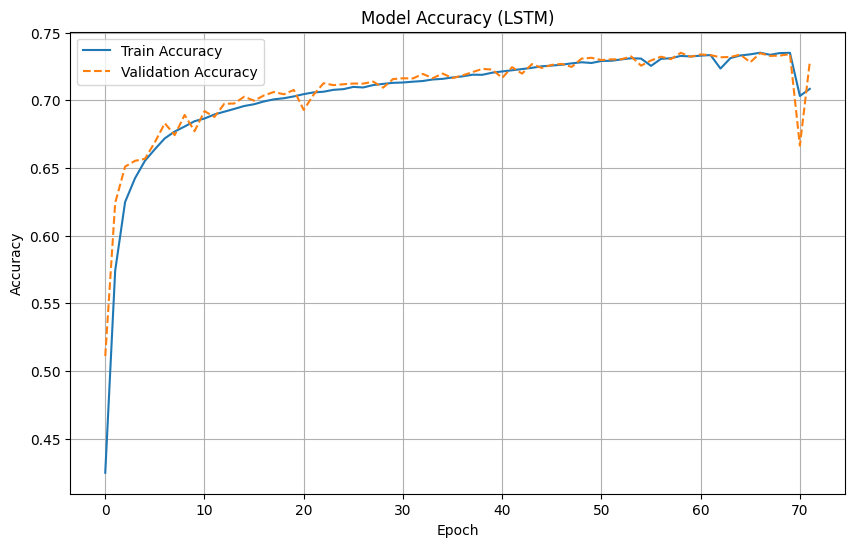

Gráfica de pérdida guardada en: ./resultados/loss_plot_LSTM.png


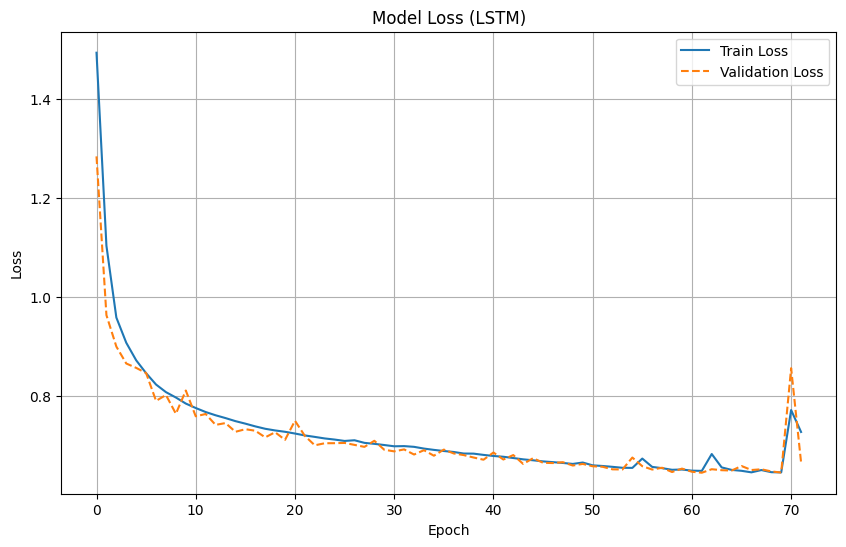

Matriz de confusión guardada como imagen en: ./resultados/confusion_matrix_LSTM.png


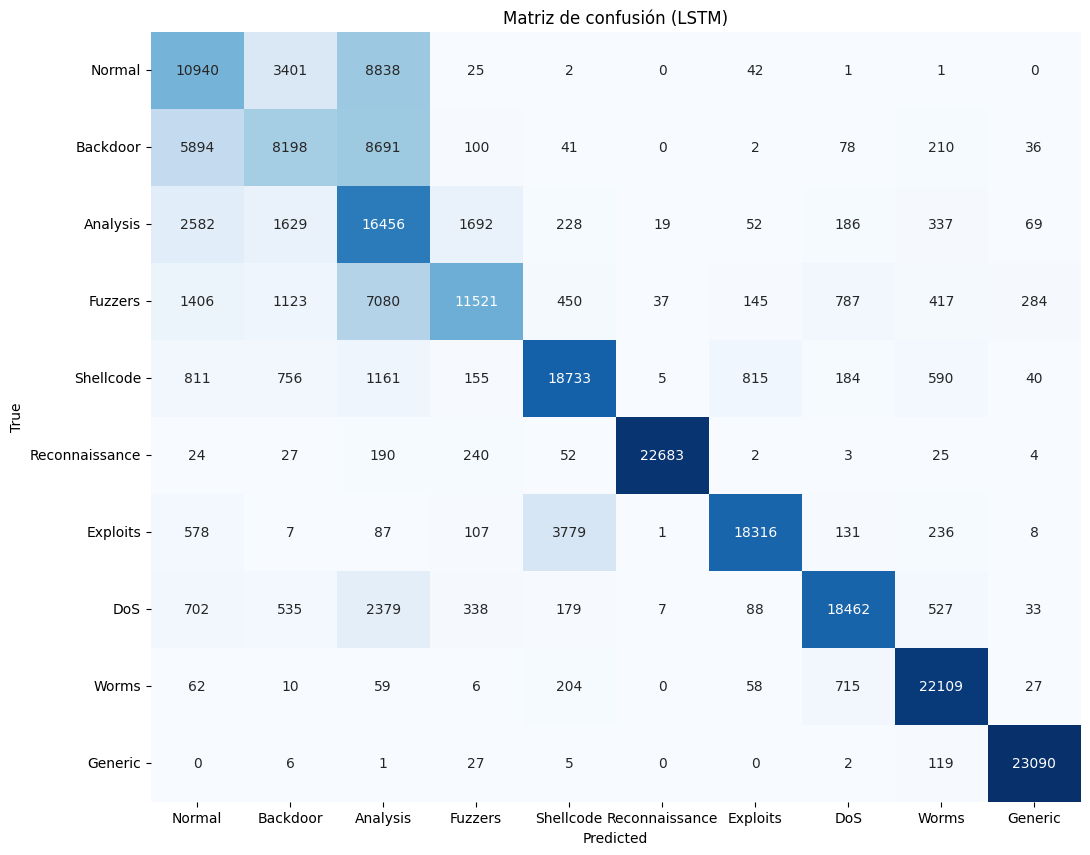

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_LSTM.png


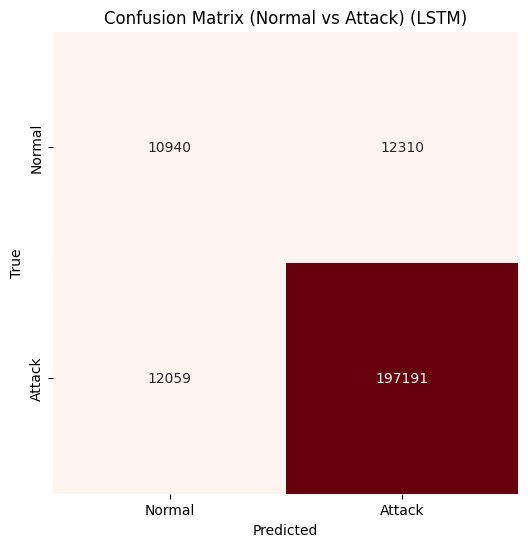

In [35]:

model_name = "LSTM"
datos = cargar_modelo_y_data(model_name)

history = datos['history']
y_true = datos['y_true']
y_pred = datos['y_pred']

# Crear gráficas y matrices
labels = ['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode', 'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']
Graficar_precision(history, model_name)
Graficar_perdida(history, model_name)
Matriz_confusion_general(y_true, y_pred, labels, model_name)
Matriz_confusion_binaria(y_true, y_pred, model_name)



Modelo cargado desde ./GRU_files\GRU_model.keras
Historial de entrenamiento cargado desde ./GRU_files\GRU_training_history.json
Predicciones cargadas desde ./GRU_files\y_pred_GRU.npy
Etiquetas reales cargadas desde ./GRU_files\y_true_GRU.npy
Gráfica de precisión guardada en: ./resultados/accuracy_plot_GRU.png


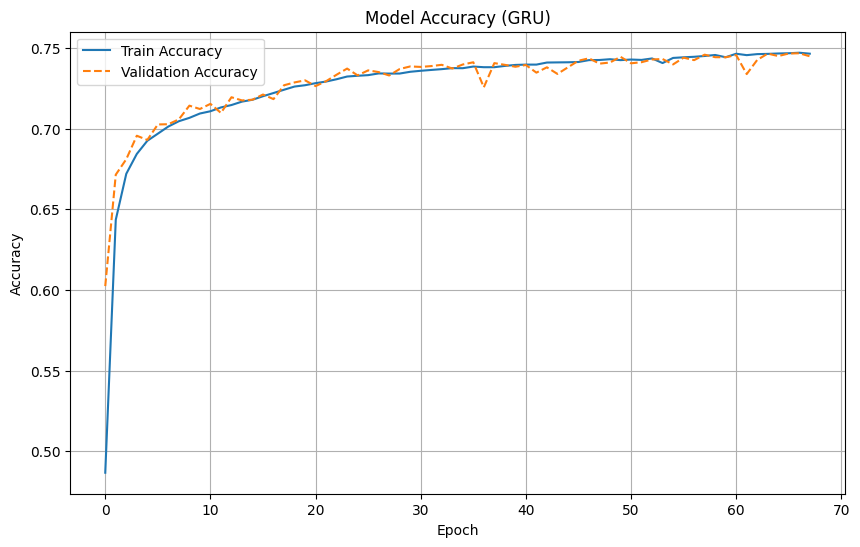

Gráfica de pérdida guardada en: ./resultados/loss_plot_GRU.png


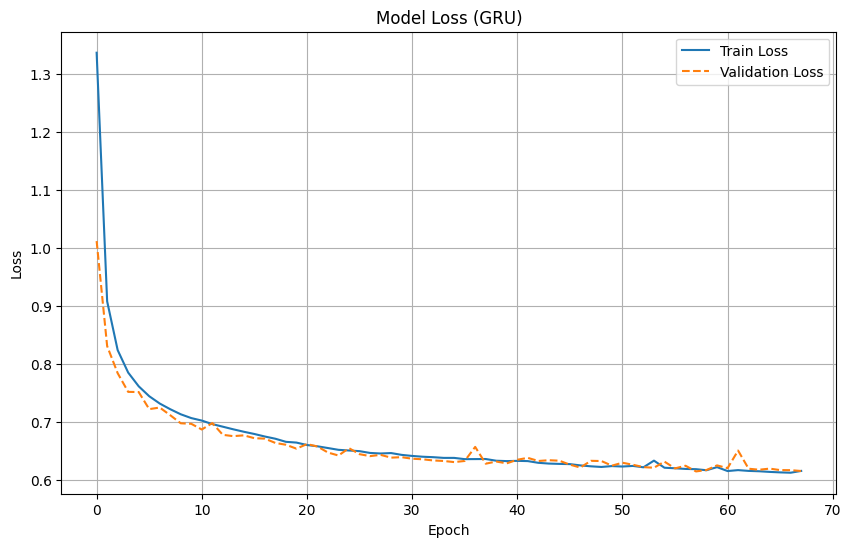

Matriz de confusión guardada como imagen en: ./resultados/confusion_matrix_GRU.png


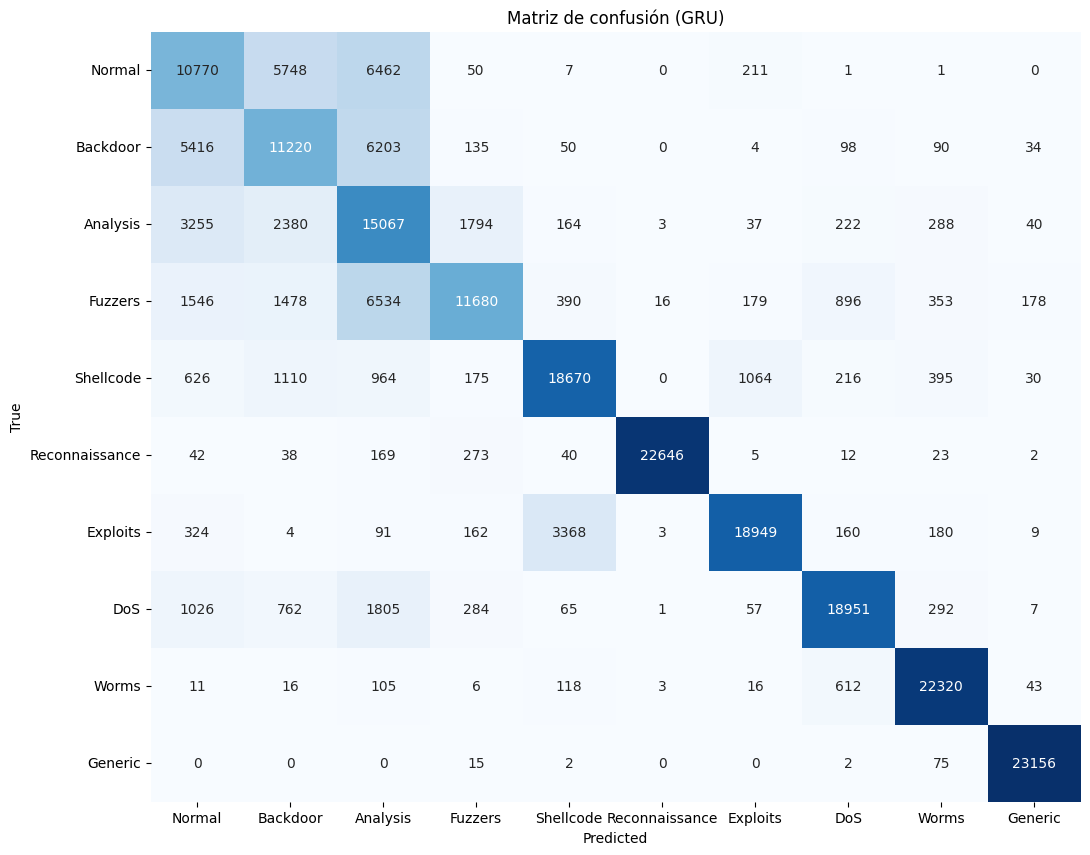

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_GRU.png


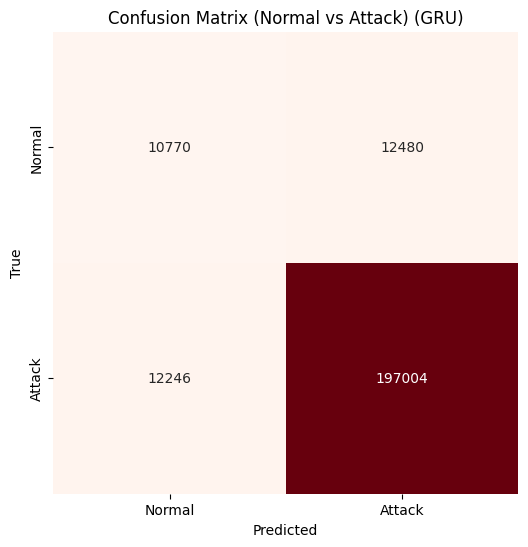

In [36]:

model_name = "GRU"
datos = cargar_modelo_y_data(model_name)

history = datos['history']
y_true = datos['y_true']
y_pred = datos['y_pred']

# Crear gráficas y matrices
labels = ['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode', 'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']
Graficar_precision(history, model_name)
Graficar_perdida(history, model_name)
Matriz_confusion_general(y_true, y_pred, labels, model_name)
Matriz_confusion_binaria(y_true, y_pred, model_name)



Modelo cargado desde ./RNN_files\RNN_model.keras
Historial de entrenamiento cargado desde ./RNN_files\RNN_training_history.json
Predicciones cargadas desde ./RNN_files\y_pred_RNN.npy
Etiquetas reales cargadas desde ./RNN_files\y_true_RNN.npy
Gráfica de precisión guardada en: ./resultados/accuracy_plot_RNN.png


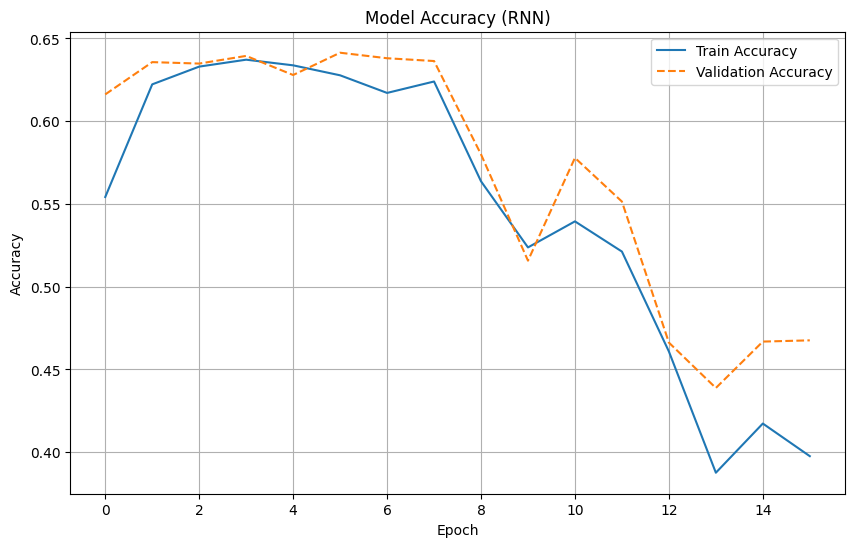

Gráfica de pérdida guardada en: ./resultados/loss_plot_RNN.png


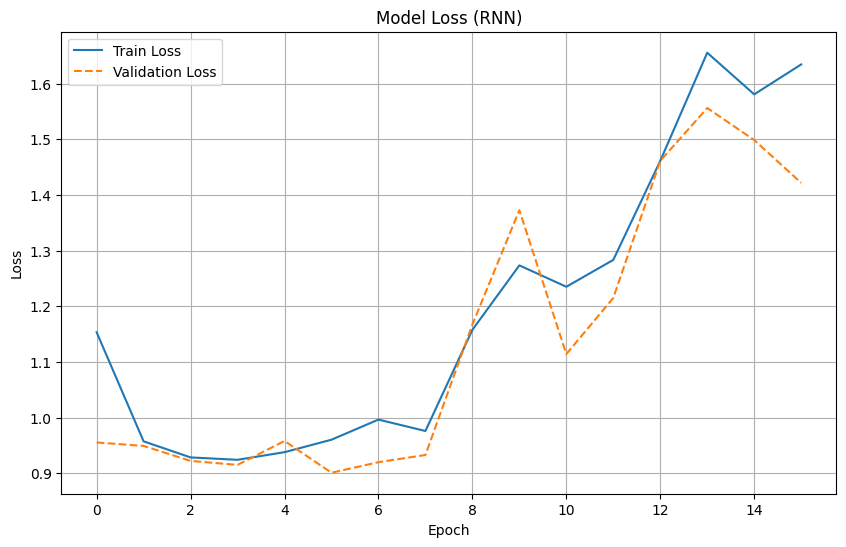

Matriz de confusión guardada como imagen en: ./resultados/confusion_matrix_RNN.png


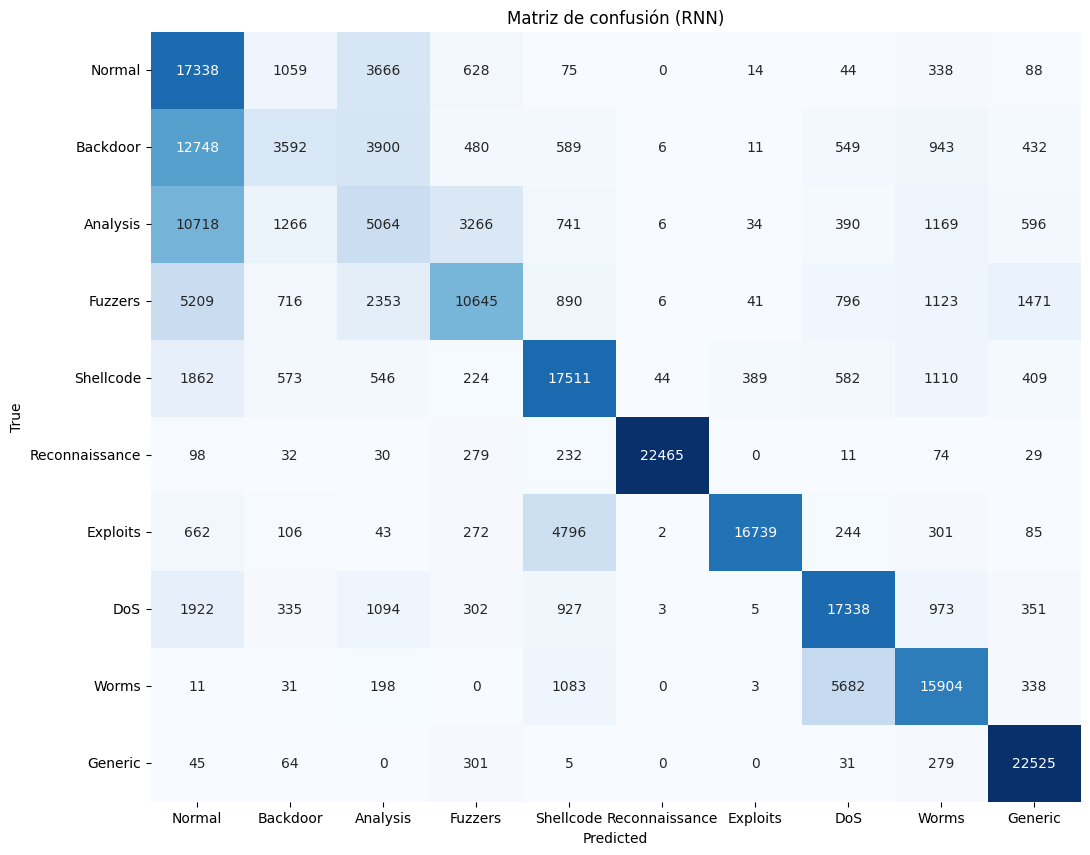

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_RNN.png


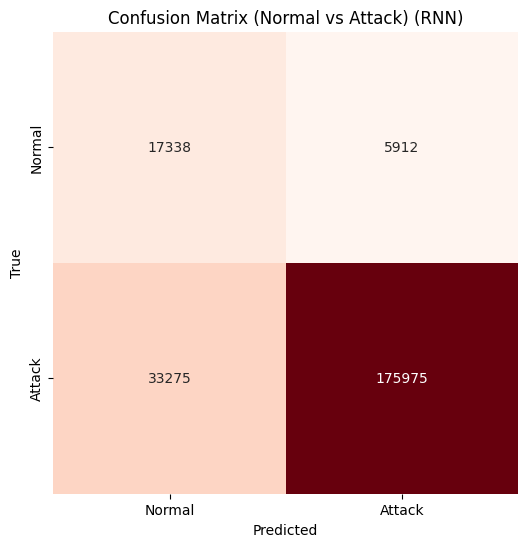

In [37]:

model_name = "RNN"
datos = cargar_modelo_y_data(model_name)

history = datos['history']
y_true = datos['y_true']
y_pred = datos['y_pred']

# Crear gráficas y matrices
labels = ['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode', 'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']
Graficar_precision(history, model_name)
Graficar_perdida(history, model_name)
Matriz_confusion_general(y_true, y_pred, labels, model_name)
Matriz_confusion_binaria(y_true, y_pred, model_name)



Gráfica de precisión guardada en: ./resultados/accuracy_plot_GRU_+_Atención_Aditiva.png


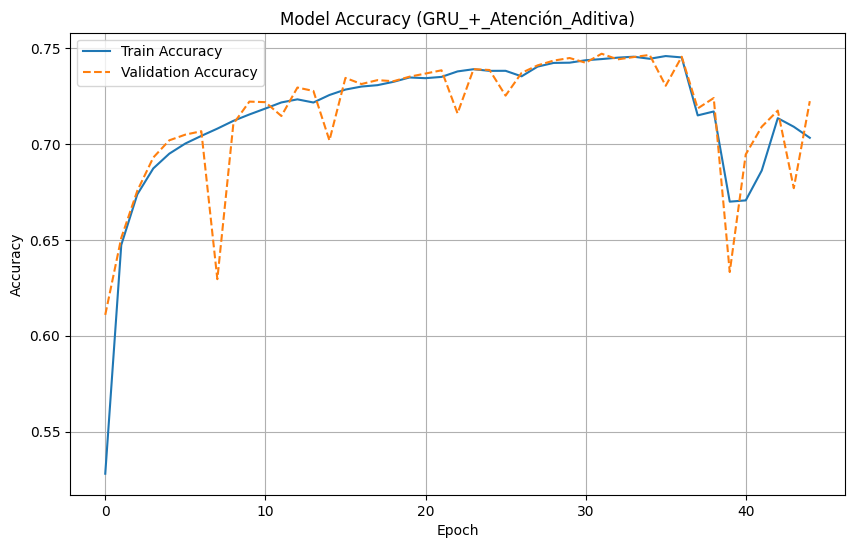

Gráfica de pérdida guardada en: ./resultados/loss_plot_GRU_+_Atención_Aditiva.png


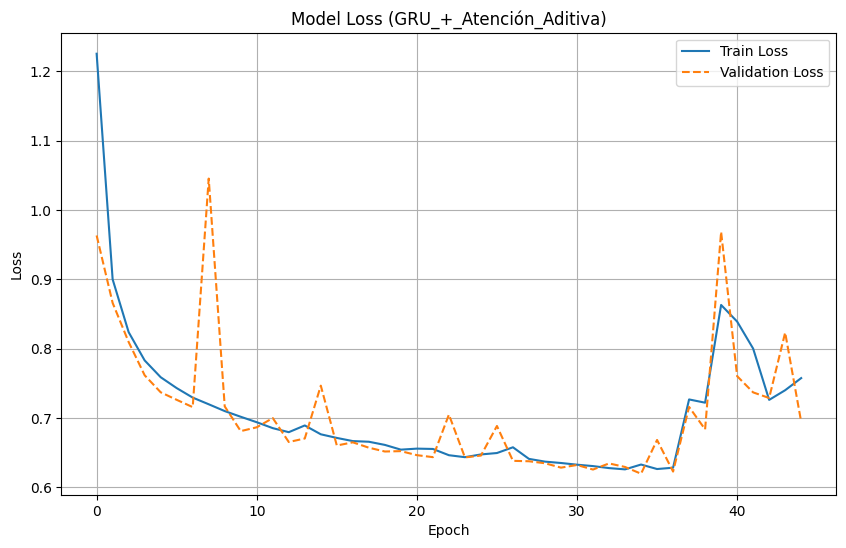

Matriz de confusión general guardada como imagen en: ./resultados/confusion_matrix_GRU_+_Atención_Aditiva.png


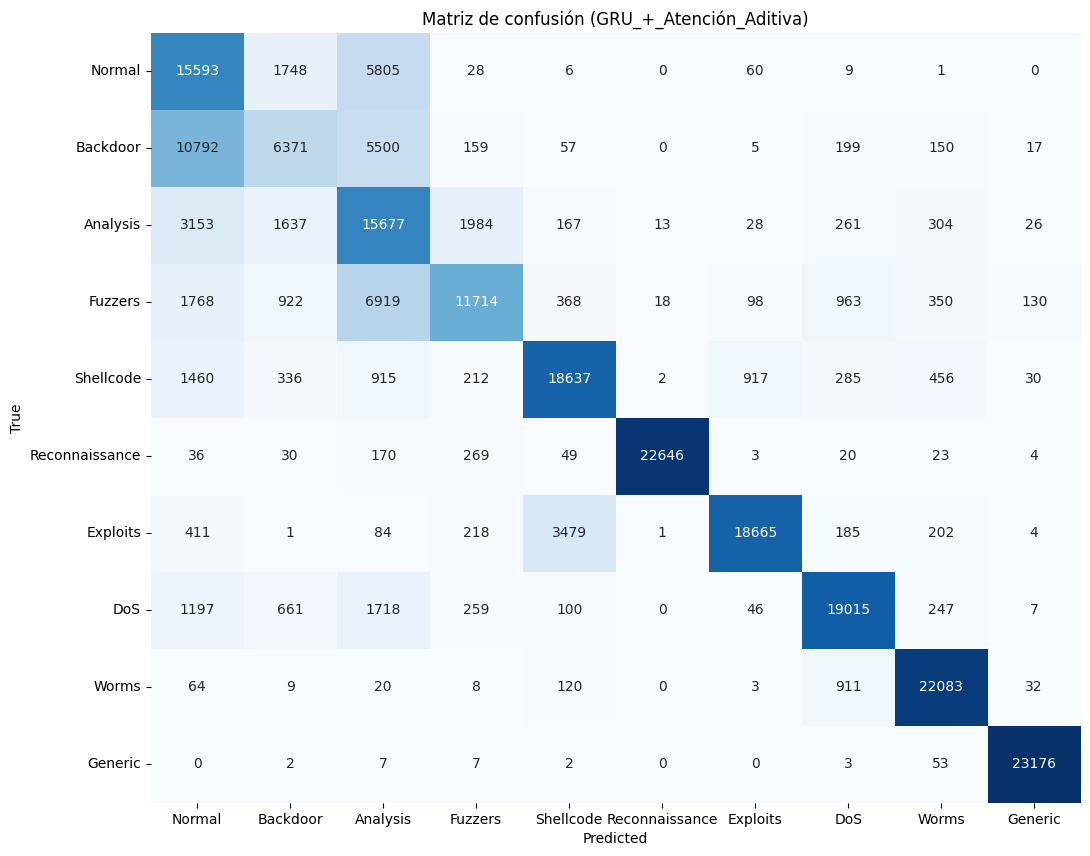

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_GRU_+_Atención_Aditiva.png


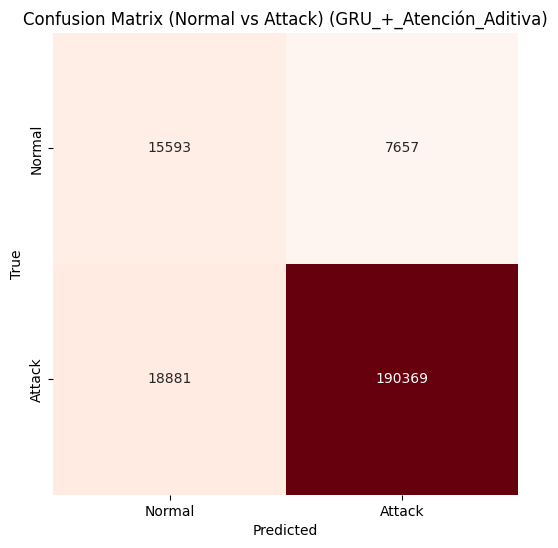

Gráfica de precisión guardada en: ./resultados/accuracy_plot_GRU_+_Atención_DotProduct.png


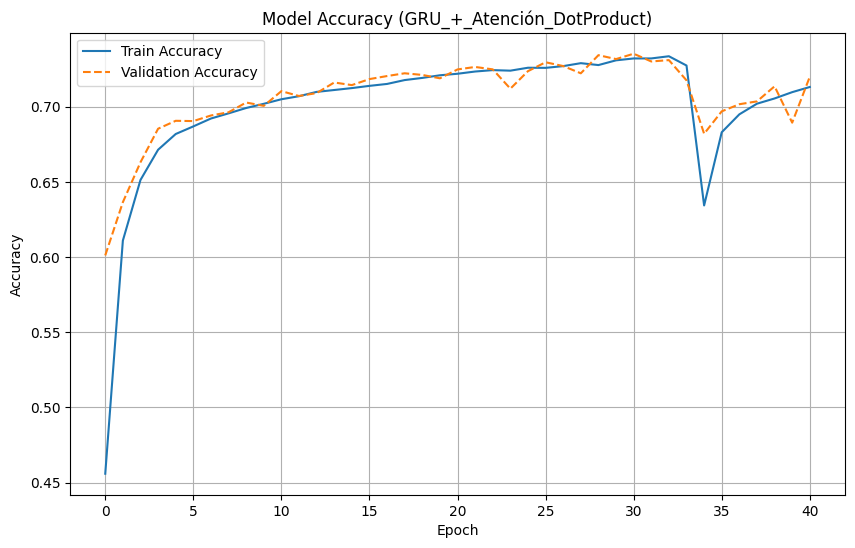

Gráfica de pérdida guardada en: ./resultados/loss_plot_GRU_+_Atención_DotProduct.png


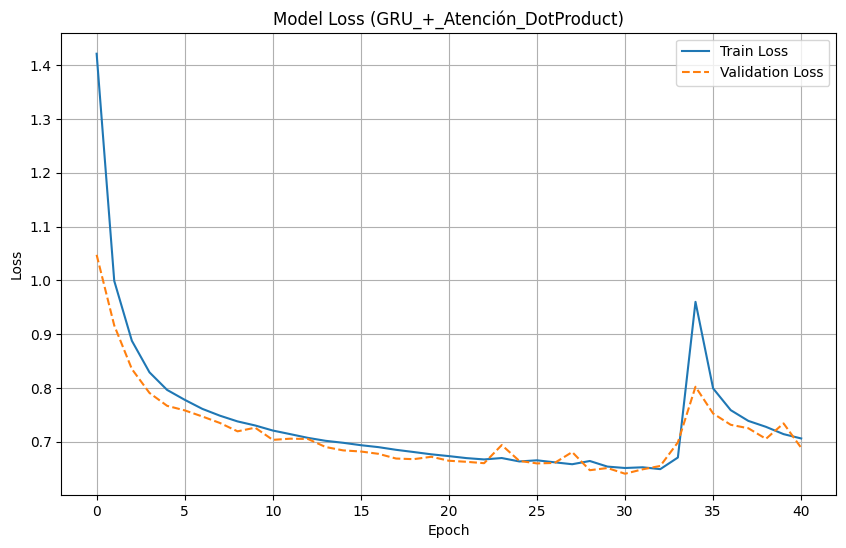

Matriz de confusión general guardada como imagen en: ./resultados/confusion_matrix_GRU_+_Atención_DotProduct.png


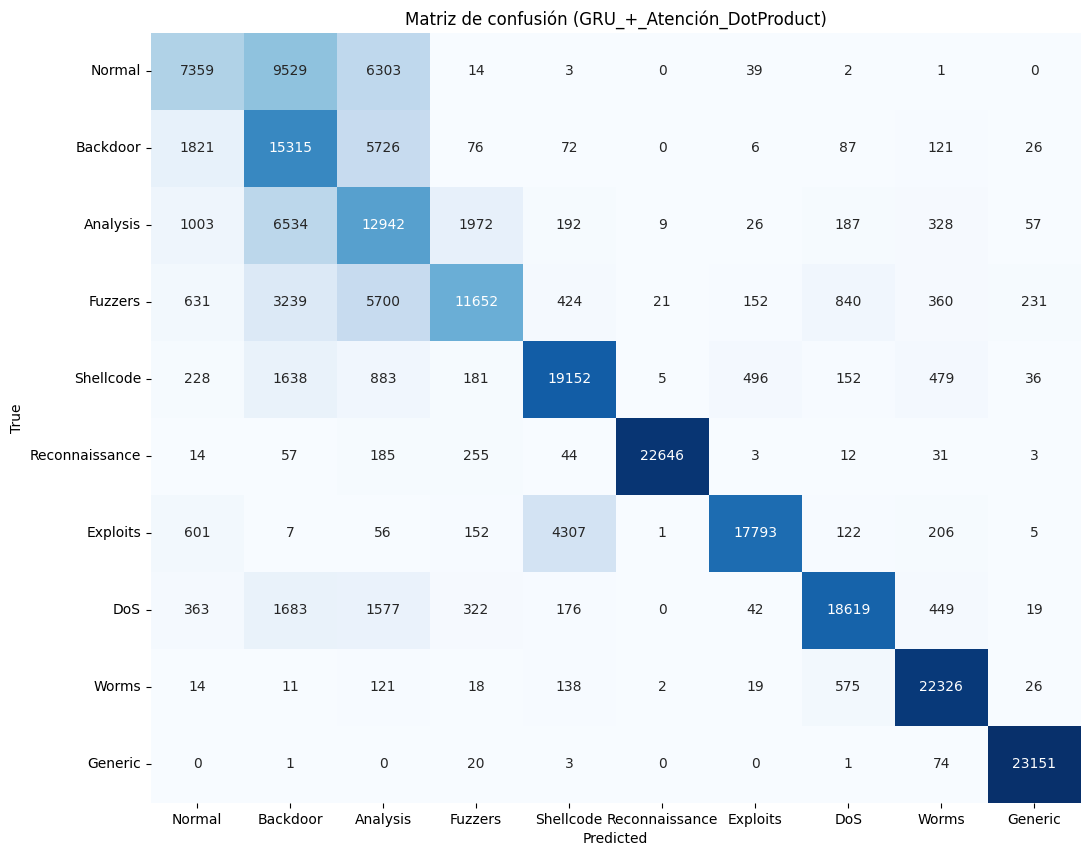

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_GRU_+_Atención_DotProduct.png


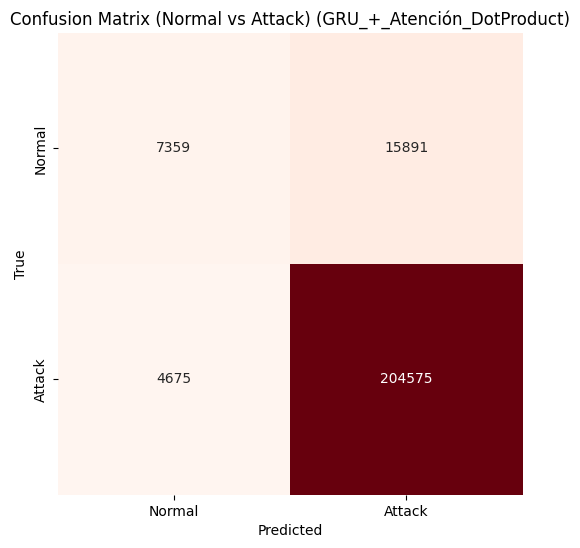

Gráfica de precisión guardada en: ./resultados/accuracy_plot_GRU_+_Atención_General.png


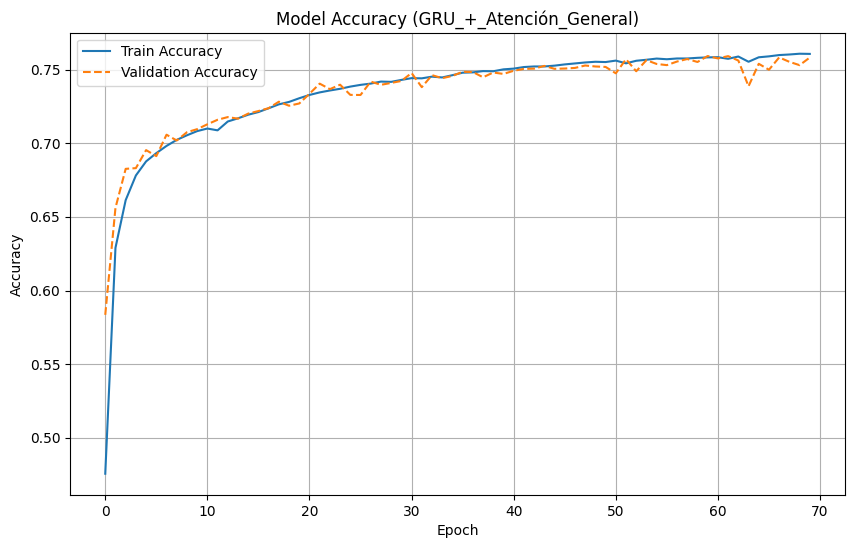

Gráfica de pérdida guardada en: ./resultados/loss_plot_GRU_+_Atención_General.png


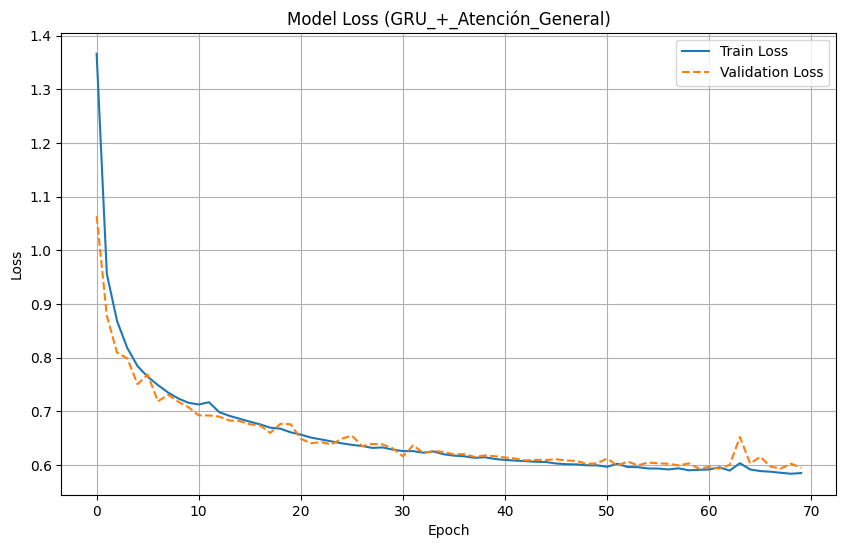

Matriz de confusión general guardada como imagen en: ./resultados/confusion_matrix_GRU_+_Atención_General.png


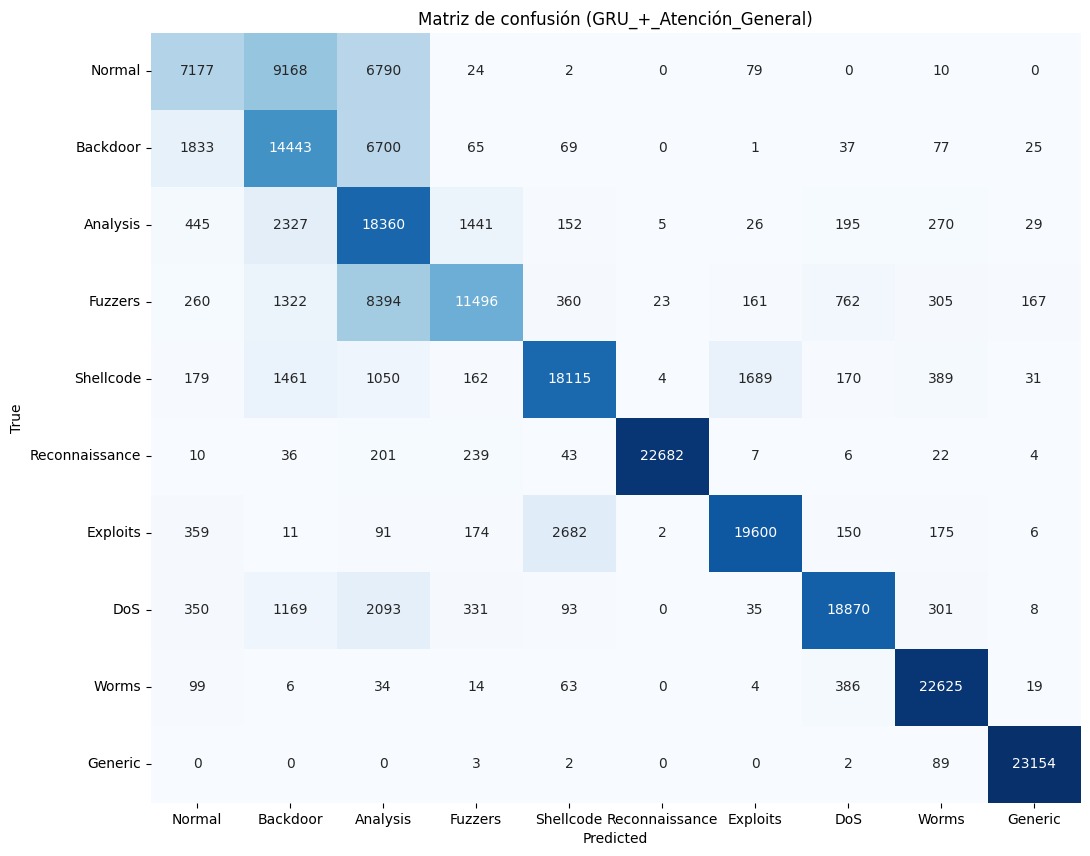

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_GRU_+_Atención_General.png


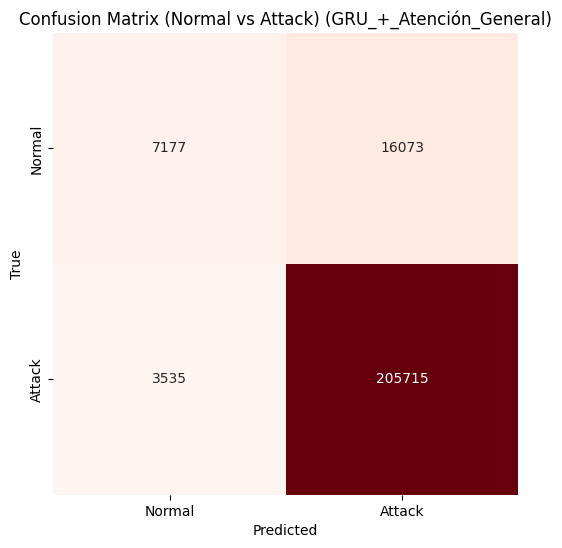

Gráfica de precisión guardada en: ./resultados/accuracy_plot_GRU_DotProduct_Escalado.png


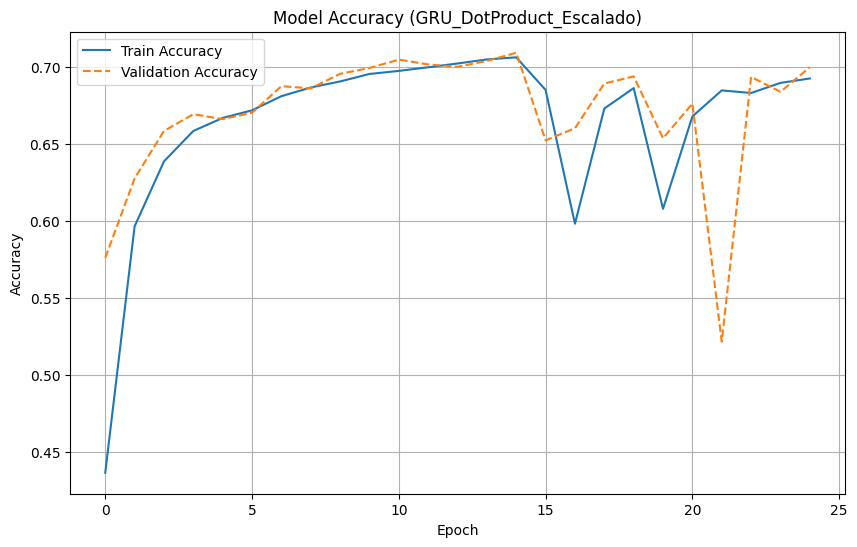

Gráfica de pérdida guardada en: ./resultados/loss_plot_GRU_DotProduct_Escalado.png


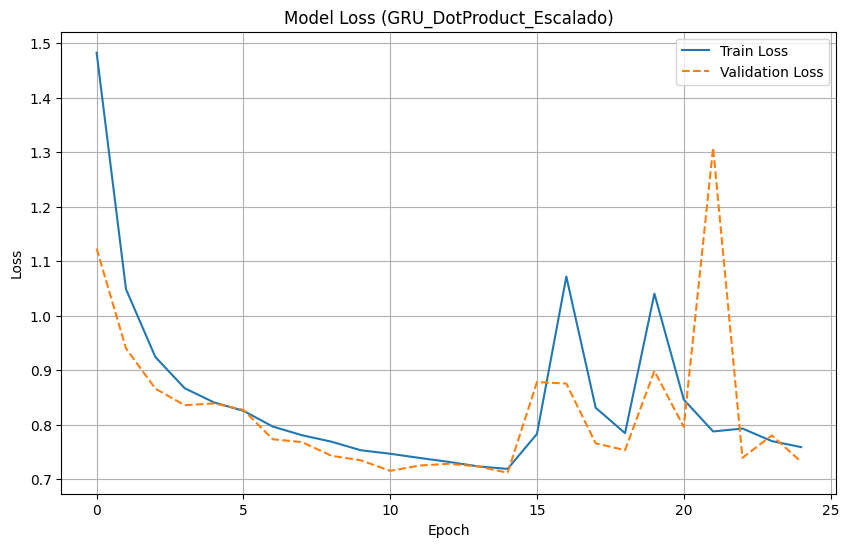

Matriz de confusión general guardada como imagen en: ./resultados/confusion_matrix_GRU_DotProduct_Escalado.png


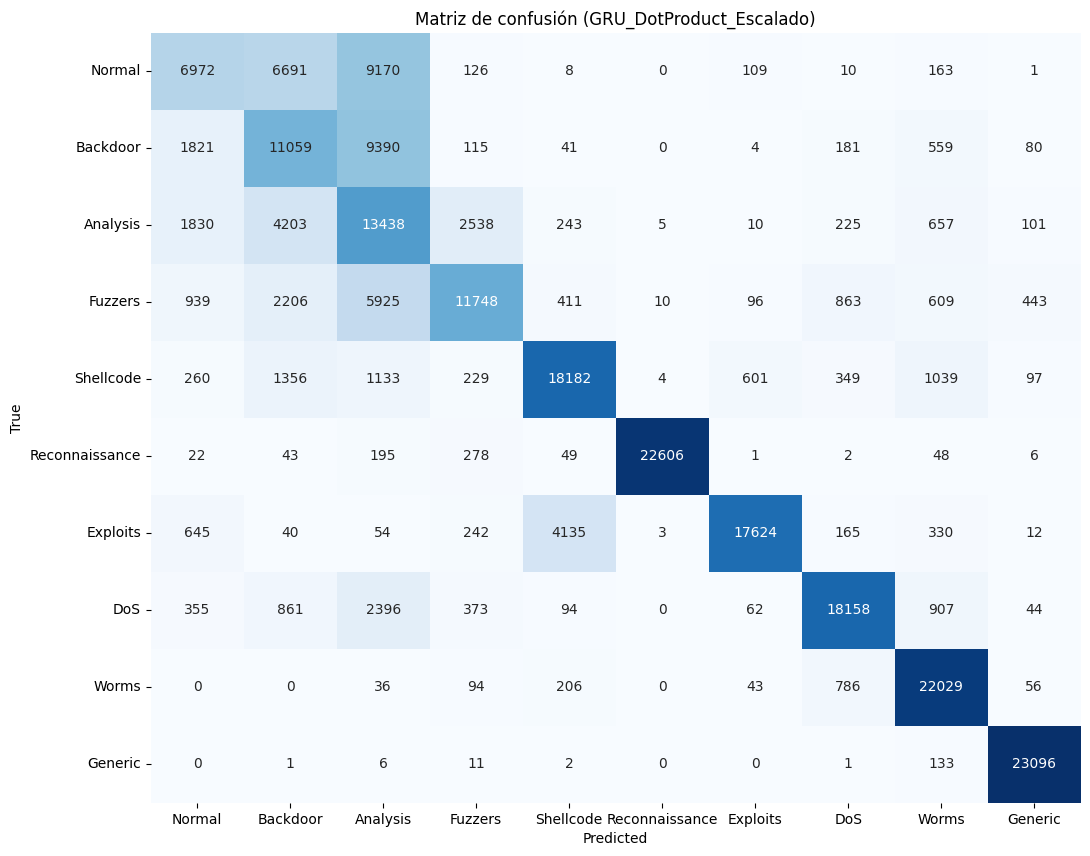

Matriz de confusión binaria guardada como imagen en: ./resultados/binary_confusion_matrix_GRU_DotProduct_Escalado.png


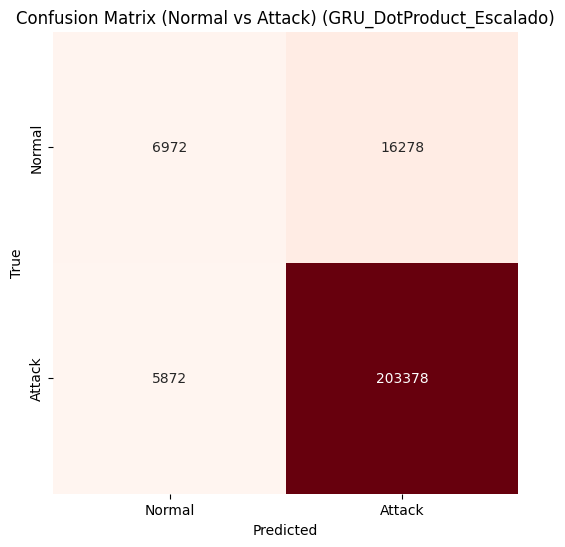

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix

# Función para cargar datos y generar gráficos
def procesar_modelo(model_name, output_dir='./resultados/'):
    # Asegurarse de que el directorio de salida exista
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Cargar historial de entrenamiento
    history_path = f'{model_name}_training_history.json'
    with open(history_path, 'r') as f:
        history = json.load(f)['history']

    # Cargar predicciones y valores reales
    y_pred = np.load(f'y_pred_{model_name}.npy')
    y_true = np.load(f'y_true_{model_name}.npy')

    # Extraer métricas del historial
    train_accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]
    train_loss = history["loss"]
    val_loss = history["val_loss"]

    # Graficar precisión
    accuracy_path = f"{output_dir}accuracy_plot_{model_name}.png"
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, label='Train Accuracy', linestyle='-')
    plt.plot(val_accuracy, label='Validation Accuracy', linestyle='--')
    plt.title(f'Model Accuracy ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(accuracy_path)
    print(f"Gráfica de precisión guardada en: {accuracy_path}")
    plt.show()

    # Graficar pérdida
    loss_path = f"{output_dir}loss_plot_{model_name}.png"
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train Loss', linestyle='-')
    plt.plot(val_loss, label='Validation Loss', linestyle='--')
    plt.title(f'Model Loss ({model_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(loss_path)
    print(f"Gráfica de pérdida guardada en: {loss_path}")
    plt.show()

    # Definir etiquetas
    labels = ['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
              'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']

    # Matriz de confusión general
    cm_general = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    general_conf_path = f"{output_dir}confusion_matrix_{model_name}.png"
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_general, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f'Matriz de confusión ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(general_conf_path)
    print(f"Matriz de confusión general guardada como imagen en: {general_conf_path}")
    plt.show()

    # Matriz de confusión binaria (Normal vs Attack)
    binary_y_true = np.array([1 if label != 0 else 0 for label in y_true])
    binary_y_pred = np.array([1 if label != 0 else 0 for label in y_pred])
    cm_binary = confusion_matrix(binary_y_true, binary_y_pred)
    binary_conf_path = f"{output_dir}binary_confusion_matrix_{model_name}.png"
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Reds', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"], cbar=False)
    plt.title(f'Confusion Matrix (Normal vs Attack) ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(binary_conf_path)
    print(f"Matriz de confusión binaria guardada como imagen en: {binary_conf_path}")
    plt.show()

# Lista de modelos
modelos = [
    "GRU_+_Atención_Aditiva",
    "GRU_+_Atención_DotProduct",
    "GRU_+_Atención_General",
    "GRU_DotProduct_Escalado"
]

# Generar gráficos para cada modelo
for modelo in modelos:
    procesar_modelo(modelo)


In [13]:
import json

# Lista de modelos
modelos = [
    "RNN",
    "LSTM",
    "GRU",
    "GRU_+_Atención_Aditiva",
    "GRU_+_Atención_DotProduct",
    "GRU_+_Atención_General",
    "GRU_DotProduct_Escalado"
]

# Directorio donde están los historiales
history_dir = './'

# Leer y mostrar los valores de accuracy y la época final
for modelo in modelos:
    history_path = f'{history_dir}{modelo}_training_history.json'
    try:
        with open(history_path, 'r') as f:
            history = json.load(f)['history']
            train_accuracy = history["accuracy"][-1]  # Último valor de accuracy de entrenamiento
            val_accuracy = history["val_accuracy"][-1]  # Último valor de accuracy de validación
            final_epoch = len(history["accuracy"])  # Época final (longitud del historial)
            
            print(f"Modelo: {modelo}")
            print(f"  - Train Accuracy: {train_accuracy:.4f}")
            print(f"  - Validation Accuracy: {val_accuracy:.4f}")
            print(f"  - Época Final: {final_epoch}")
    except FileNotFoundError:
        print(f"Archivo de historial no encontrado para el modelo: {modelo}")
    except KeyError:
        print(f"Estructura inesperada en el archivo de historial para el modelo: {modelo}")


Archivo de historial no encontrado para el modelo: RNN
Modelo: LSTM
  - Train Accuracy: 0.7085
  - Validation Accuracy: 0.7284
  - Época Final: 72
Modelo: GRU
  - Train Accuracy: 0.7465
  - Validation Accuracy: 0.7449
  - Época Final: 68
Modelo: GRU_+_Atención_Aditiva
  - Train Accuracy: 0.7033
  - Validation Accuracy: 0.7224
  - Época Final: 45
Modelo: GRU_+_Atención_DotProduct
  - Train Accuracy: 0.7132
  - Validation Accuracy: 0.7200
  - Época Final: 41
Modelo: GRU_+_Atención_General
  - Train Accuracy: 0.7607
  - Validation Accuracy: 0.7582
  - Época Final: 70
Modelo: GRU_DotProduct_Escalado
  - Train Accuracy: 0.6926
  - Validation Accuracy: 0.6999
  - Época Final: 25
